## Tutorial #5: Applying Machine Learning Methods to EEG Data on Group Level

In this tutorial, same classification tasks in Tutorial-4 will be examined but this time analysis will be done on group level.

##### Dataset: 
The the previous tutorial data of the only one participant in 'Emotion-Antecedent Appraisal Checks: EEG and EMG data sets for Novelty and Pleasantness' is used. In this tutorial, all participans will be included

In [1]:
# For elimiating warnings
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [20]:
import mne
from os.path import isfile, join
from os import listdir
import numpy as np
import statistics
from mne.decoding import Vectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from pprint import pprint

from scipy import stats

# Models
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [3]:
#Load Dataset
data_folder = '../../study1/study1_eeg/epochdata/'
files = [data_folder+f for f in listdir(data_folder) if isfile(join(data_folder, f)) and '.DS_Store' not in f]
ids = [int(f[-6:-4]) for f in files]

numberOfEpochs = np.zeros((len(ids), 3))
# Read the EEG epochs:
epochs_all_UN, epochs_all_UP, epochs_all_NP = [], [], []
for f in range(len(files)):
    epochs = mne.read_epochs(files[f], verbose='error')
    epochs_UN = epochs['FU', 'FN']
    epochs_UP = epochs['FU', 'FP']
    epochs_NP = epochs['FN', 'FP']
    numberOfEpochs[f,0] = int(len(epochs_UN.events))
    numberOfEpochs[f,1] = int(len(epochs_UP.events))
    numberOfEpochs[f,2] = int(len(epochs_NP.events))
    UN, UP, NP = [ids[f]], [ids[f]], [ids[f]]
    UN.append(epochs_UN)
    UP.append(epochs_UP)
    NP.append(epochs_NP)
    epochs_all_UN.append(UN)
    epochs_all_UP.append(UP)
    epochs_all_NP.append(NP)

#print(numberOfEpochs)
epochs_all_UN = np.array(epochs_all_UN)
epochs_all_UP = np.array(epochs_all_UP)
epochs_all_NP = np.array(epochs_all_NP)

In [4]:
print('Shape of epochs_UN: {}'.format(epochs_all_UN.shape))
print('Shape of epochs_UP: {}'.format(epochs_all_UP.shape))
print('Shape of epochs_NP: {}'.format(epochs_all_NP.shape))

Shape of epochs_UN: (25, 2)
Shape of epochs_UP: (25, 2)
Shape of epochs_NP: (25, 2)


Separating data, labels and the ids of the participants for modelling

In [5]:
def getData_labels(epochs):
    data, labels, ids = [], [], []
    for p in epochs:
        tmp_epoch = p[1]
        tmp_labels = tmp_epoch.events[:,-1]
        labels.extend(tmp_labels)
        tmp_id = p[0]
        ids.extend([tmp_id]*len(tmp_labels))
        data.extend(tmp_epoch.get_data())
        
    data = np.array(data)
    labels = np.array(labels)
    ids = np.array(ids)
    return data, labels, ids

### Example #1:  Classification between Unpleasant and Pleasant Events

In [6]:
data_UP, labels_UP, ids_UP = getData_labels(epochs_all_UP)

Standard score calculation is done by simply calculating accuracy regardless of the participant. The following function calculates and returns accuracy per participant.

In [23]:
def calculate_score_groupLevel(ids, predictions, labels):
    print('ids: ', ids)
    print('predictions: ')
    pprint( predictions)
    print('labels: ')
    pprint(labels)
    unique_ids = list(set(ids))
    print('unique: ', unique_ids)
    results = []
    for id in unique_ids:
        indices = [i for i, x in enumerate(ids) if x == id]
        print('len indices: ', len(indices))
        res = 0
        for i in range(len(indices)):
            if predictions[indices[i]] == labels[indices[i]]:
                res += 1
        print('res: ', res)
        results.append(res/len(indices))
    
    return results, unique_ids

Create all models and then run cross validation for all of them for comparing their performances.

In [17]:
# Linear Discriminant Analysis
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
#Logistic Regression
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(penalty='l1', random_state=42))

models = [clf_lda_pip] #clf_lr_pip
model_names = [ 'LDA'] #'LR', 

In [24]:
def applyCrossValidation(models, model_names, ids, data, labels, kfold):
    results, results_perParticipant, unique_ids_all = [], [], []
    
    if np.all(np.isfinite(data)) == True and np.any(np.isnan(data)) == False:
        for i in range(len(models)):
            print(model_names[i])
            predictions = cross_val_predict(models[i], data, labels, cv=kfold)
            cv_accuracy_perparticipant, unique_ids = calculate_score_groupLevel(ids, predictions, labels)
            results_perParticipant.append(cv_accuracy_perparticipant)
            unique_ids_all.append(unique_ids)
            cv_accuracy = cross_val_score(models[i], data, labels, cv=kfold)
            results.append(cv_accuracy)
            print('CV accuracy of model ' + model_names[i] + ': ' + str(cv_accuracy))
            print('CV accuracy of model ' + model_names[i] + ' per participant: ' + str(cv_accuracy_perparticipant))
    else:
        print('Data has infinite or NaN value!')
    
    return results, results_perParticipant, unique_ids_all

In [ ]:
kfold = StratifiedKFold(n_splits=3, random_state=42)
results, results_perParticipant, unique_ids_all = applyCrossValidation(models, model_names, ids_UP, data_UP, labels_UP, kfold)

LDA


/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/envs/pinar/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [15]:
mean_CVaccuracies, std_CVaccuracies = [], []

Claculate mean and standard deviation of cross validation scores for each model

In [16]:
print('Results UP: {}'.format(results))
mean_CVaccuracies_UP, std_CVaccuracies_UP = [], []
for i in range(len(results)):
    mean_CVaccuracies_UP.append(statistics.mean(results[i]))
    std_CVaccuracies_UP.append(statistics.stdev(results[i]))
print('Mean cv accuracies UP: {}'.format(mean_CVaccuracies_UP))
print('Std cv accuracies UP: {}'.format(std_CVaccuracies_UP))
print('\n')
mean_CVaccuracies.append(mean_CVaccuracies_UP)
std_CVaccuracies.append(std_CVaccuracies_UP)
print('Mean cv accuracies: {}'.format(mean_CVaccuracies))
print('Std cv accuracies: {}'.format(std_CVaccuracies))

Results UP: [array([0.38266017, 0.34912892, 0.37377964]), array([0.32625348, 0.31358885, 0.28870293])]
Mean cv accuracies UP: [0.36852290812317, 0.3095150869795531]
Std cv accuracies UP: [0.017372709567566594, 0.01910386526397282]


Mean cv accuracies: [[0.36852290812317, 0.3095150869795531]]
Std cv accuracies: [[0.017372709567566594, 0.01910386526397282]]


!!!! Not sure if the following plot makes sense!!!

The following function plots lda and logistic regression scores for each partipant

In [17]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
def plotCVScores_perParticipant(unique_ids, results, model_names):
    
    fig, ax = plt.subplots()
    fig.suptitle('CV Accuracy Scores per Participant')
    for i in range(len(results)):
        if model_names[i] == 'LR':
            color = 'ro'
        else:
            color = 'bo'
        ax.plot(ids, results[i], color, label=model_names[i])
    plt.xlabel('Participant IDs')
    plt.ylabel('Accuracy')
    ax.legend()
    plt.show()

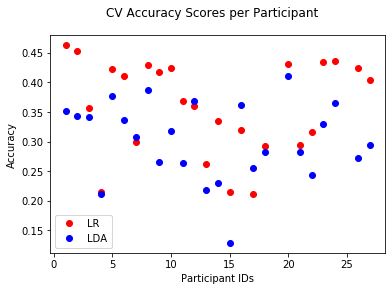

In [18]:
plotCVScores_perParticipant(unique_ids_all, results_perParticipant, model_names)

Box plots shows how given data is distributed around the mean of the data and also it highlights the outliers.

In [19]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def plotModelComparison(results, model_names):
    fig = plt.figure()
    fig.suptitle('Model Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(model_names)
    plt.show()

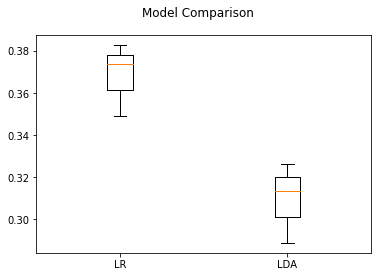

In [20]:
plotModelComparison(results, model_names)

Independent t-test is applied to statistically show whether there is a significant difference between performace of two models. Small p-value means that performace of models are significantly different, large p-value indicates that models are performing similar. In general, as the threshold for determining whether two distributions are different or not, p = 0.05 which corresponds to 95% confidence level is preffered.

In [21]:
def applyTTest(results, model_names):
    if len(results) < 2:
        print('Not enough values for t-test!')
    else:
        for i in range(len(results)):
            for j in range(i+1,len(results)):
                t, p = stats.ttest_ind(results[i],results[j])
                print("p = {0} for t-test between {1} and {2}".format(p,  model_names[i],  model_names[j]))

In [22]:
applyTTest(results, model_names)

p = 0.016704736667900663 for t-test between LR and LDA


Since p-value is smaller than 0.05, we can conclude that there is a significant difference between performance of LDA and performance of LR on the task of classification between unpleasant and pleasant events.

### Example #2:  Classification between Unpleasant and Neutral Events

In [23]:
# Dataset with unpleasant and neutral events
data_UN, labels_UN, ids_UN = getData_labels(epochs_all_UN)

In [24]:
# Linear Discriminant Analysis
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
#Logistic Regression
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(penalty='l1', random_state=42))
models = [ clf_lr_pip, clf_lda_pip]
model_names = [ 'LR', 'LDA']

In [ ]:
kfold = StratifiedKFold(n_splits=3, random_state=42)
results_UN, results_perParticipant_UN = applyCrossValidation(models, model_names, ids_UN, data_UN, labels_UN, kfold)    

LR


In [ ]:
print(results_UN)
mean_CVaccuracies_UN, std_CVaccuracies_UN = [], []

for i in range(len(results_UN)):
    mean_CVaccuracies_UN.append(statistics.mean(results_UN[i]))
    std_CVaccuracies_UN.append(statistics.stdev(results_UN[i]))

mean_CVaccuracies.append(mean_CVaccuracies_UN)
std_CVaccuracies.append(std_CVaccuracies_UN)
print(mean_CVaccuracies)
print(std_CVaccuracies)

In [ ]:
plotModelComparison(results_UN, model_names)

In [ ]:
applyTTest(results_UN, model_names)

Since p-value is smaller than 0.05, we can conclude that there is a significant difference between performance of LDA and performance of LR on the task of classification between unpleasant and neutral events.

### Example #3: Classification between Pleasant and Neutral Events

In [ ]:
# Dataset with unpleasant and neutral events
data_NP, labels_NP, ids_NP = getData_labels(epochs_all_NP)

In [ ]:
# Linear Discriminant Analysis
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
#Logistic Regression
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(penalty='l1', random_state=42))
models = [ clf_lr_pip, clf_lda_pip]
model_names = [ 'LR', 'LDA']

In [ ]:
kfold = StratifiedKFold(n_splits=3, random_state=42)
results_NP, results_perParticipant_NP = applyCrossValidation(models, model_names, ids_NP, data_NP, labels_NP, kfold) 

In [ ]:
print(results_NP)
mean_CVaccuracies_NP, std_CVaccuracies_NP = [], []

for i in range(len(results_NP)):
    mean_CVaccuracies_NP.append(statistics.mean(results_NP[i]))
    std_CVaccuracies_NP.append(statistics.stdev(results_NP[i]))

mean_CVaccuracies.append(mean_CVaccuracies_NP)
std_CVaccuracies.append(std_CVaccuracies_NP)
print(mean_CVaccuracies)
print(std_CVaccuracies)

In [ ]:
plotModelComparison(results_NP, model_names)

In [ ]:
applyTTest(results_NP, model_names)

Since p-value is larger than 0.05, we can conclude that there is a significant difference between performance of LDA and performance of LR on the task of classification between neutral and pleasant events.

#### Comparing Performance of Models Over Different Tasks

In [ ]:
def plotEvalMetrics(tasks, labels, evalMetric, metricName):
    width = 0.2  # the width of the bars

    # Set position of bar on X axis
    rects1 = np.arange(len(evalMetric))
    rects2 = [x + width for x in rects1]
    rects3 = [x + width for x in rects2]

    plt.bar(rects1, list(zip(*evalMetric))[0], color='#87CEFA', width=width, edgecolor='white', label=labels[0])
    plt.bar(rects2, list(zip(*evalMetric))[1], color='#FFE4E1', width=width, edgecolor='white', label=labels[1])
    
    plt.xlabel('Classification Tasks')
    plt.xticks([r + width/2 for r in range(len(evalMetric))], tasks)
    plt.ylabel(metricName)

    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', )
    plt.show()

In [ ]:
#Plot Mean Accuracies
tasks = ['UN', 'UP', 'NP']
labels = ['LDA', 'LR']
plotEvalMetrics(tasks, labels, mean_CVaccuracies, 'Mean CV Accuracy')

In [ ]:
#Plot Std of Accuracies
tasks = ['UN', 'UP', 'NP']
labels = ['LDA', 'LR']
plotEvalMetrics(tasks, labels, std_CVaccuracies, 'Std of CV Accuracies ')

As part of group level analysis of eeg data, logistic regression (lr) and linear discriminant analysis (lda) are created as in the previous tutorial but this time svm is omitted because it requires hours to build with the amount of data we have. 

The first plot above showed the mean cross validation for both LDA and Logistic Regression on each task. While classifying between Unpleasant and Neutral events, both model provided accuracy around 50% which is the highest score among all tasks. For other two classification tasks, Lda performed better. It can be concluded that classification between Unpleasant and Pleasant events is the most difficult task for the models since both of them provided poor performance.